In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shopping-trends-and-customer-behaviour-dataset/Shopping Trends And Customer Behaviour Dataset.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Exploration

In [3]:
# Load data and view first 5 rows
df = pd.read_csv('/kaggle/input/shopping-trends-and-customer-behaviour-dataset/Shopping Trends And Customer Behaviour Dataset.csv')
df.head()

,Unnamed: 0,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,0,1,55,Male,Blouse,Clothing,53,Kentucky,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,1,2,19,Male,Sweater,Clothing,64,Maine,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,2,3,50,Male,Jeans,Clothing,73,Massachusetts,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,3,4,21,Male,Sandals,Footwear,90,Rhode Island,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,4,5,45,Male,Blouse,Clothing,49,Oregon,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


In [4]:
# Check basic info
print("Dataset Info:") 
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              3900 non-null   int64  
 1   Customer ID             3900 non-null   int64  
 2   Age                     3900 non-null   int64  
 3   Gender                  3900 non-null   object 
 4   Item Purchased          3900 non-null   object 
 5   Category                3900 non-null   object 
 6   Purchase Amount (USD)   3900 non-null   int64  
 7   Location                3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         39

In [5]:
# Check for missing values
print("Missing Values:") 
df.isnull().sum()

Missing Values:


Unnamed: 0                0
Customer ID               0
Age                       0
Gender                    0
Item Purchased            0
Category                  0
Purchase Amount (USD)     0
Location                  0
Color                     0
Season                    0
Review Rating             0
Subscription Status       0
Shipping Type             0
Discount Applied          0
Promo Code Used           0
Previous Purchases        0
Payment Method            0
Frequency of Purchases    0
dtype: int64

In [6]:
# Check for duplicates
print("Number of Duplicate Rows:")
df.duplicated().sum()

Number of Duplicate Rows:


0

In [7]:
# Summary statistics for numerical columns
print("Summary Statistics for Numerical Columns:")
print(df.describe())

Summary Statistics for Numerical Columns:
        Unnamed: 0  Customer ID          Age  Purchase Amount (USD)  \
count  3900.000000  3900.000000  3900.000000            3900.000000   
mean   1949.500000  1950.500000    44.068462              59.764359   
std    1125.977353  1125.977353    15.207589              23.685392   
min       0.000000     1.000000    18.000000              20.000000   
25%     974.750000   975.750000    31.000000              39.000000   
50%    1949.500000  1950.500000    44.000000              60.000000   
75%    2924.250000  2925.250000    57.000000              81.000000   
max    3899.000000  3900.000000    70.000000             100.000000   

       Review Rating  Previous Purchases  
count    3900.000000         3900.000000  
mean        3.749949           25.351538  
std         0.716223           14.447125  
min         2.500000            1.000000  
25%         3.100000           13.000000  
50%         3.700000           25.000000  
75%         4.400

In [8]:
# Summary statistics for categorical columns
print("Summary Statistics for Categorical Columns:") 
print(df.describe(include='object'))

Summary Statistics for Categorical Columns:
       Gender Item Purchased  Category Location  Color  Season  \
count    3900           3900      3900     3900   3900    3900   
unique      2             25         4       50     25       4   
top      Male         Blouse  Clothing  Montana  Olive  Spring   
freq     2652            171      1737       96    177     999   

       Subscription Status  Shipping Type Discount Applied Promo Code Used  \
count                 3900           3900             3900            3900   
unique                   2              6                2               2   
top                     No  Free Shipping               No              No   
freq                  2847            675             2223            2223   

       Payment Method Frequency of Purchases  
count            3900                   3900  
unique              6                      7  
top            PayPal         Every 3 Months  
freq              677                    584  

#### **Observations**

**1. Data Quality:**

- No missing values.
- No duplicates.
- **Redundant Columns:** Unnamed: 0 and Customer ID appear to be identifiers with no analytical value for segmentation. These should be dropped to avoid noise in the model.

**2. Numerical Features:**

- **Age:** Ranges from 18 to 70 (mean ≈ 44, std ≈ 15.21). It shows a diverse distribution suitable for demographic-based segmentation.
- **Purchase Amount (USD):** Ranges from 20 to 100 (mean ≈ 59.76, std ≈ 23.69), a sign of varied spending behavior. The distribution appears fairly uniform, but we’ll confirm with visualizations.
- **Review Rating:** Ranges from 2.5 to 5.0 (mean ≈ 3.75, std ≈ 0.72) which is a suggestion of moderate customer satisfaction with some variability.
- **Previous Purchases:** Ranges from 1 to 50 (mean ≈ 25.35, std ≈ 14.45). This reflects diverse purchase histories that could indicate loyalty or engagement levels.

**3. Categorical Features:**

- **Gender:88 Male (68%, 2,652 rows) dominates over Female, which may influence segment characteristics (e.g., product preferences).
- **Item Purchased:** 25 unique items, with “Blouse” most frequent. High cardinality may require grouping or encoding strategies.
- **Category:** 4 categories, with “Clothing” dominant. This suggests a focus on apparel-related segments.
- **Location:** 50 unique locations, likely U.S. states, with “Montana” most frequent. High cardinality may necessitate regional grouping or dimensionality reduction.
- **Color:** 25 unique colors, with “Olive” most common. This feature may reflect aesthetic preferences but could be noisy for clustering unless correlated with purchases.
- **Season:** 4 seasons, with “Spring” most frequent, an indication of potential seasonal purchasing patterns.
- **Subscription Status:** 73% (2,847 rows) are non-subscribers, which could differentiate loyal vs. occasional customers.
- **Shipping Type:** 6 types, with “Free Shipping” most common (675 rows), potentially linked to purchase amount or promotions.
- **Discount Applied and Promo Code Used:** Both binary, with 57% (2,223 rows) indicating “No,” suggesting promotions are used by a significant minority.
- **Payment Method:** 6 methods, with “PayPal” most frequent (677 rows), which may reflect customer trust or convenience preferences.
- **Frequency of Purchases:** 7 frequencies, with “Every 3 Months” most common (58 rows, though frequency seems low—possible data issue or typo in output). This feature is critical for behavioral segmentation.
  
**4. Implications for Next Steps:**

- **Feature Selection:** Drop Unnamed: 0 and Customer ID as they are non-informative. Evaluate high-cardinality features (Location, Item Purchased, Color) for relevance or dimensionality reduction.
- **Encoding:** Binary categorical features (Gender, Subscription Status, Discount Applied, Promo Code Used) can be label-encoded. High-cardinality features may require one-hot encoding or target encoding to balance dimensionality.
- **Scaling:** Numerical features (Age, Purchase Amount (USD), Previous Purchases, Review Rating) have different scales, necessitating standardization (e.g., StandardScaler) for clustering algorithms like K-Means.
- **Feature Engineering:** Create derived features, such as average purchase amount per transaction or purchase frequency normalized by time, to capture behavioral patterns.
- **EDA:** Visualize distributions (histograms, boxplots) and relationships (correlation matrices, pair plots) to confirm assumptions and identify key drivers for segmentation.

## 2. Preprocessing and Feature Engineering

In [9]:
# Drop non-informative columns
df = df.drop(['Unnamed: 0', 'Customer ID'], axis=1)

In [10]:
# Check Frequency of Purchases distribution
print("Frequency of Purchases Distribution:")
print(df['Frequency of Purchases'].value_counts())
print("\n")

Frequency of Purchases Distribution:
Frequency of Purchases
Every 3 Months    584
Annually          572
Quarterly         563
Monthly           553
Bi-Weekly         547
Fortnightly       542
Weekly            539
Name: count, dtype: int64




In [11]:
# Binary encoding for categorical variables with two unique values
binary_cols = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used']
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [12]:
# One-hot encoding for low-cardinality categorical variables
low_cardinality_cols = ['Category', 'Season', 'Shipping Type', 'Payment Method', 'Frequency of Purchases']
df = pd.get_dummies(df, columns=low_cardinality_cols, prefix=low_cardinality_cols)

In [13]:
# Handle high-cardinality features (Location, Item Purchased, Color)
# For simplicity, we'll drop Color and Item Purchased due to high cardinality and questionable clustering value
# Group Location into regions 
us_regions = {
    'Northeast': ['Maine', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New Hampshire', 'Vermont', 'New York', 'Pennsylvania', 'New Jersey'],
    'South': ['Kentucky', 'Virginia', 'Tennessee', 'North Carolina', 'South Carolina', 'Georgia', 'Alabama', 'Mississippi', 'Arkansas', 'Louisiana', 'Florida'],
    'Midwest': ['Ohio', 'Michigan', 'Indiana', 'Wisconsin', 'Illinois', 'Minnesota', 'Iowa', 'Missouri', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas'],
    'West': ['Montana', 'Oregon', 'Washington', 'California', 'Nevada', 'Idaho', 'Utah', 'Arizona', 'Colorado', 'New Mexico', 'Wyoming', 'Alaska', 'Hawaii']
}
def map_region(location):
    for region, states in us_regions.items():
        if location in states:
            return region
    return 'Other'
df['Region'] = df['Location'].apply(map_region)
df = pd.get_dummies(df, columns=['Region'], prefix='Region')
df = df.drop(['Location', 'Item Purchased', 'Color'], axis=1)

In [14]:
# Feature engineering
# Average purchase amount per previous purchase
df['Avg Purchase Amount'] = df['Purchase Amount (USD)'] / (df['Previous Purchases'] + 1)  # Add 1 to avoid division by zero
# Purchase frequency score (convert Frequency of Purchases to numerical, already one-hot encoded)

In [15]:
# Scale numerical features
numerical_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Avg Purchase Amount']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [16]:
# Create a copy of the preprocessed DataFrame for hyperparameter tuning
df_copy = df.copy()

## 3. EDA

In [17]:
# Set plot style for better visualization
sns.set(style="whitegrid")

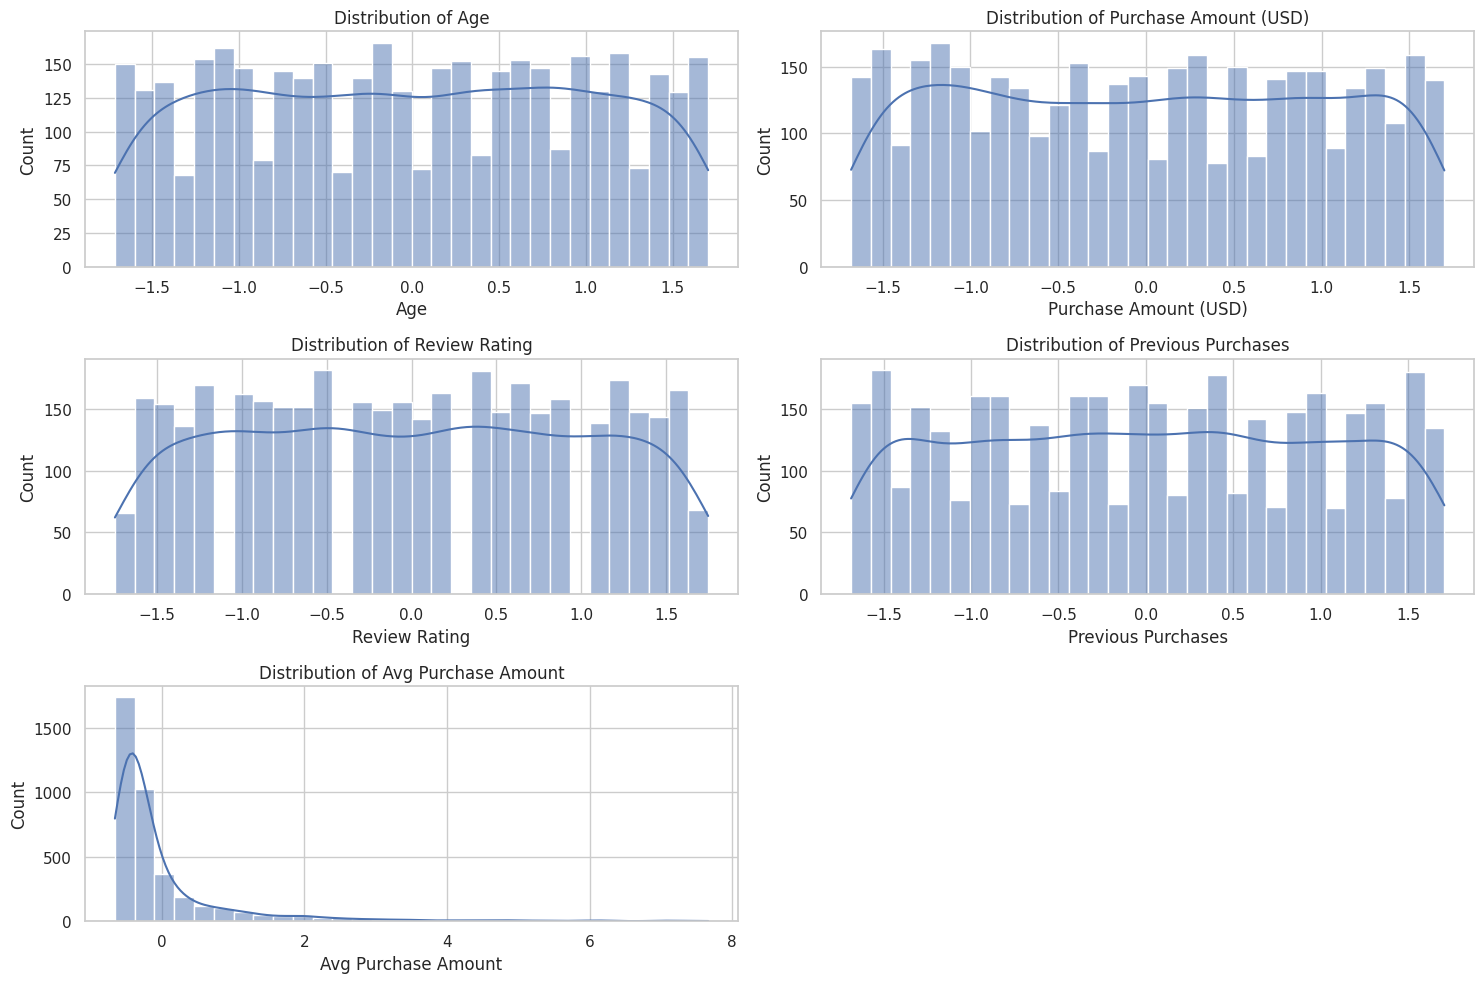

In [18]:
# Histograms for numerical features
numerical_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Avg Purchase Amount']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

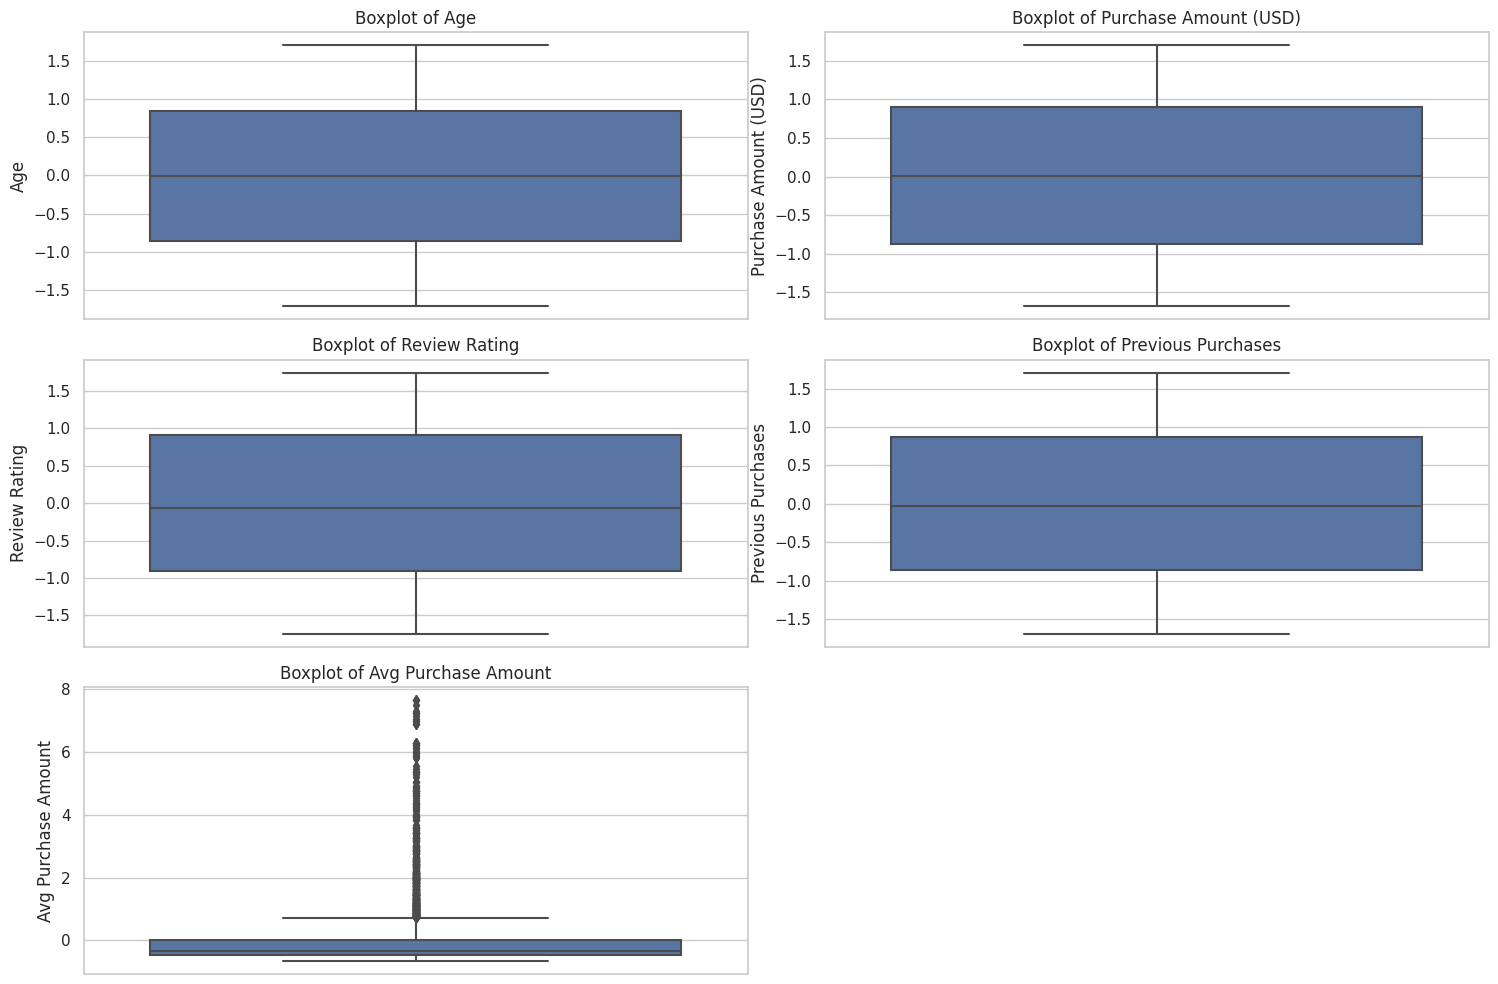

In [19]:
# Boxplots for numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

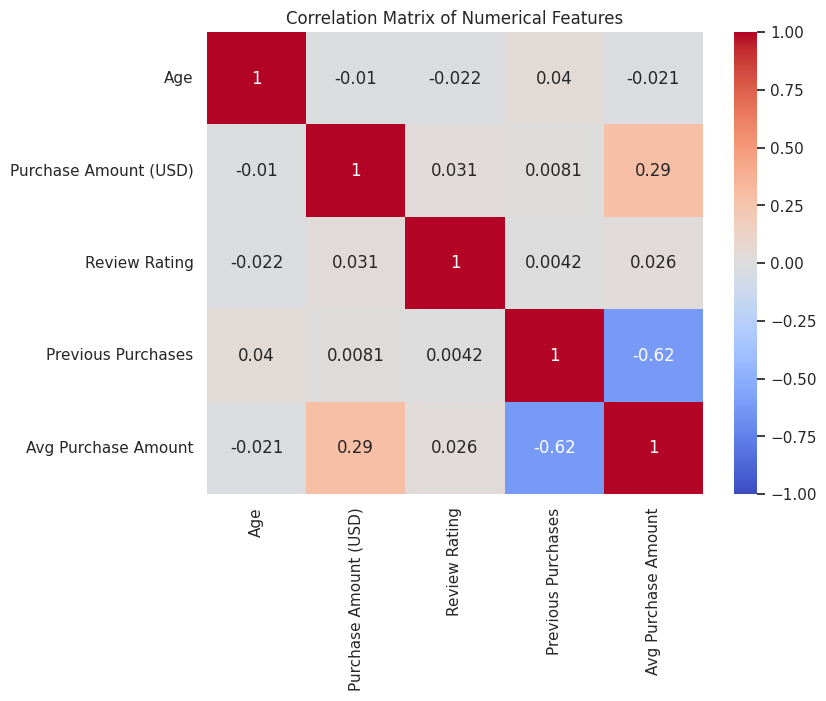

In [20]:
# Correlation matrix for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

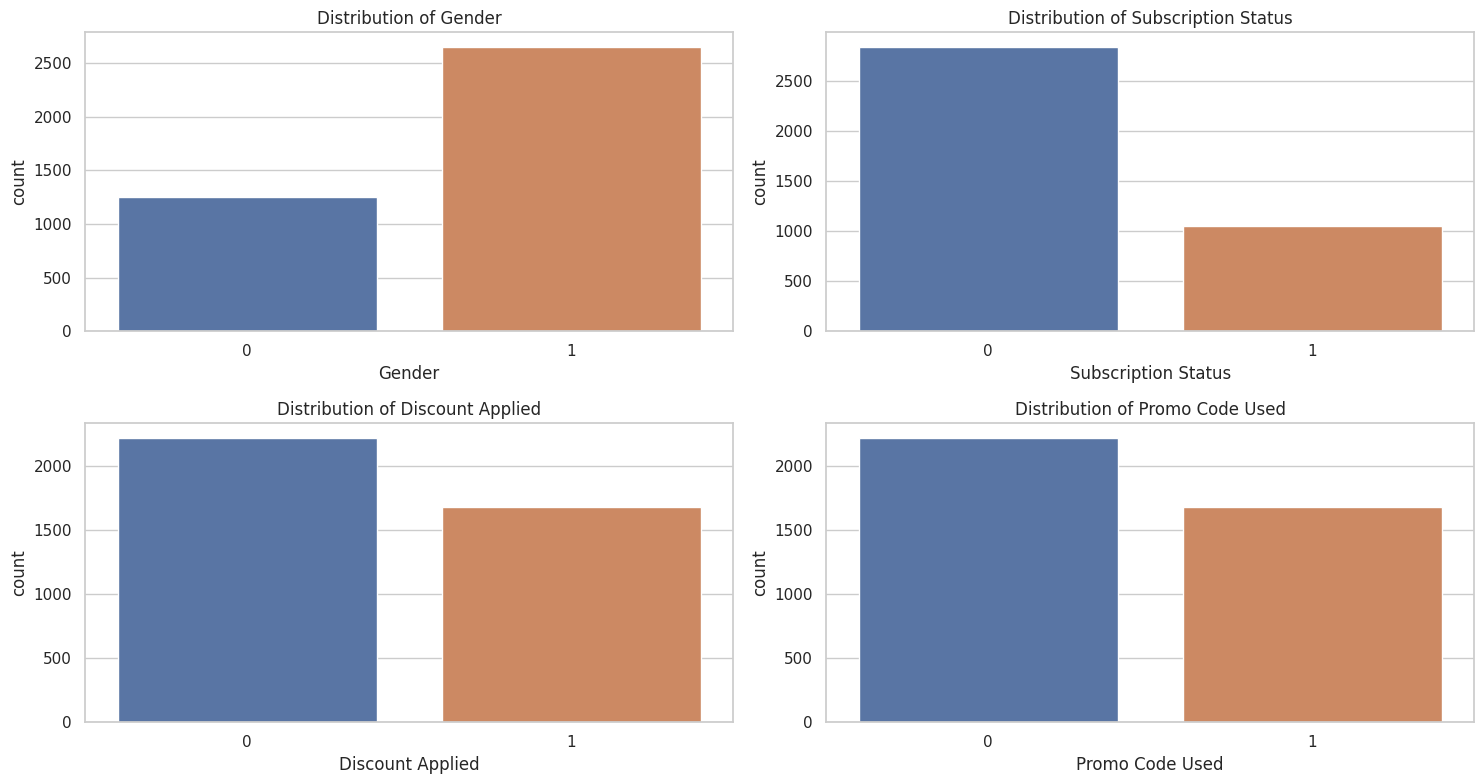

In [21]:
# Bar plots for key categorical features
categorical_cols = ['Gender', 'Subscription Status', 'Discount Applied', 'Promo Code Used']
plt.figure(figsize=(15, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df[col])
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

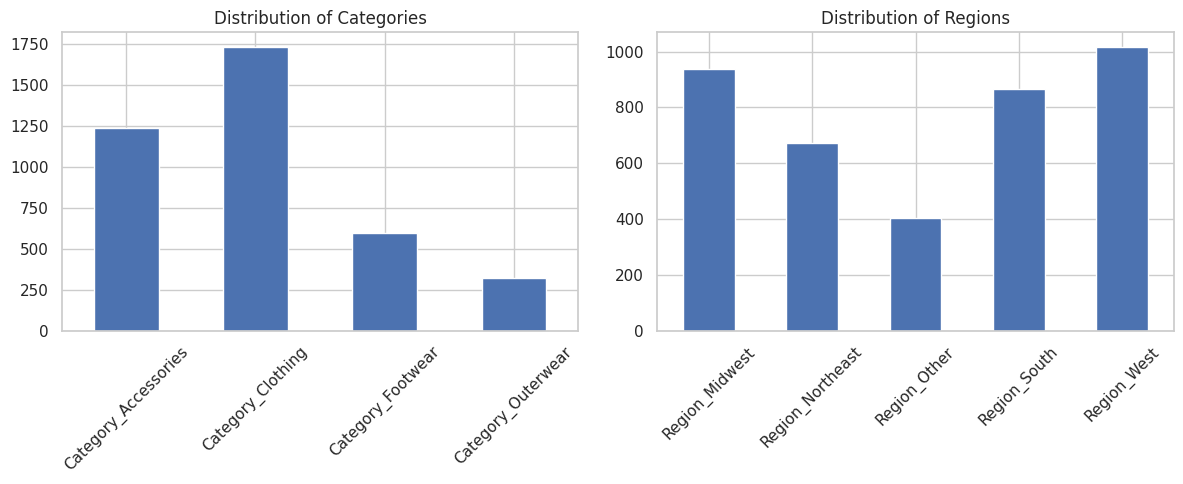

In [22]:
# Bar plot for one-hot encoded categories 
category_cols = [col for col in df.columns if col.startswith('Category_')]
region_cols = [col for col in df.columns if col.startswith('Region_')]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
df[category_cols].sum().plot(kind='bar')
plt.title('Distribution of Categories')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
df[region_cols].sum().plot(kind='bar')
plt.title('Distribution of Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

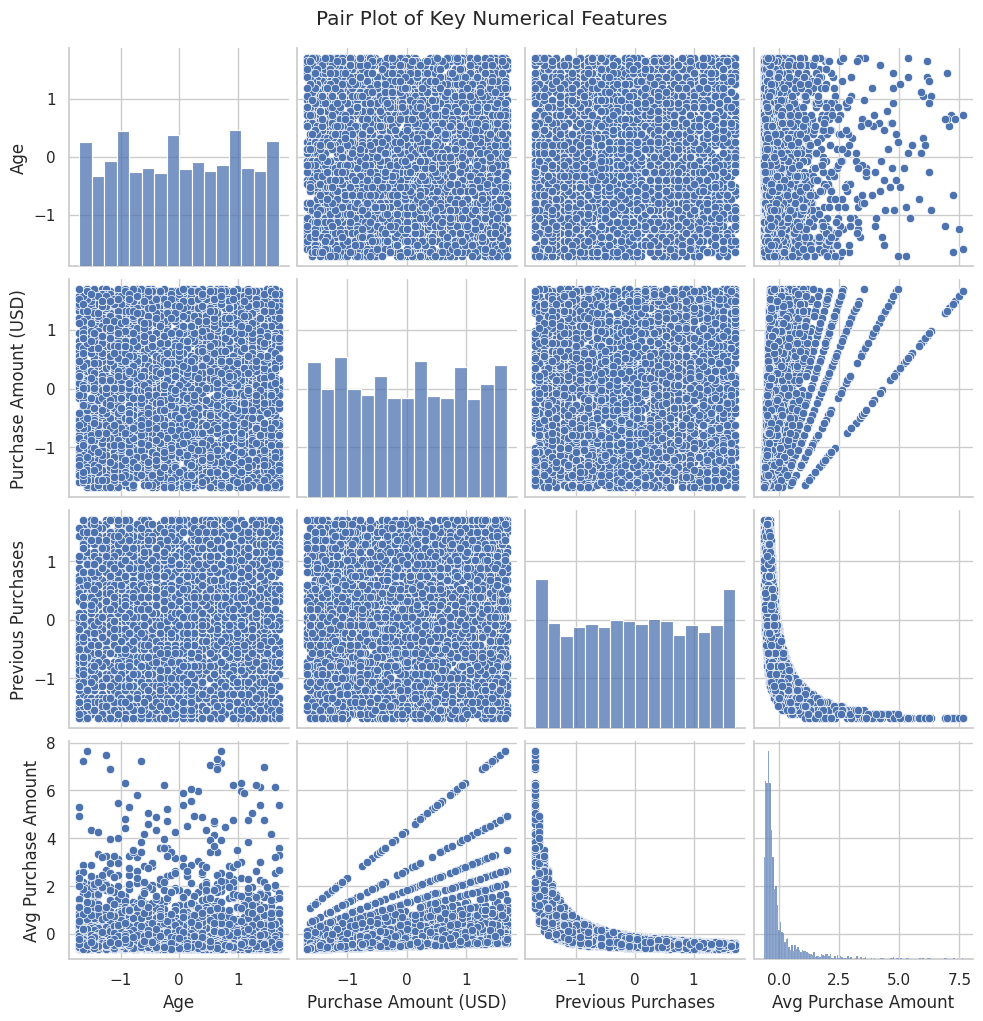

In [23]:
# Pair plot for numerical features (subset for speed)
subset_cols = ['Age', 'Purchase Amount (USD)', 'Previous Purchases', 'Avg Purchase Amount']
sns.pairplot(df[subset_cols])
plt.suptitle('Pair Plot of Key Numerical Features', y=1.02)
plt.show()

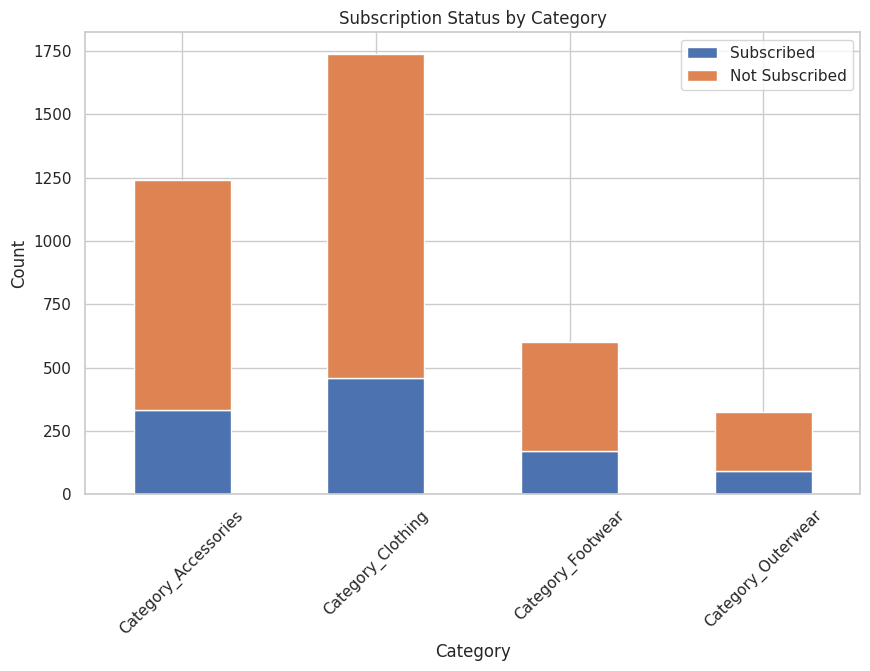

In [24]:
# Stacked bar plot for Subscription Status vs. Category
category_sums = df[category_cols].multiply(df['Subscription Status'], axis=0).sum()
category_totals = df[category_cols].sum()
stacked_data = pd.DataFrame({
    'Subscribed': category_sums,
    'Not Subscribed': category_totals - category_sums
})
stacked_data.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Subscription Status by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [25]:
# Print column names for reference
print("DataFrame Columns:")
print(df.columns)

DataFrame Columns:
Index(['Age', 'Gender', 'Purchase Amount (USD)', 'Review Rating',
       'Subscription Status', 'Discount Applied', 'Promo Code Used',
       'Previous Purchases', 'Category_Accessories', 'Category_Clothing',
       'Category_Footwear', 'Category_Outerwear', 'Season_Fall',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Shipping Type_2-Day Shipping', 'Shipping Type_Express',
       'Shipping Type_Free Shipping', 'Shipping Type_Next Day Air',
       'Shipping Type_Standard', 'Shipping Type_Store Pickup',
       'Payment Method_Bank Transfer', 'Payment Method_Cash',
       'Payment Method_Credit Card', 'Payment Method_Debit Card',
       'Payment Method_PayPal', 'Payment Method_Venmo',
       'Frequency of Purchases_Annually', 'Frequency of Purchases_Bi-Weekly',
       'Frequency of Purchases_Every 3 Months',
       'Frequency of Purchases_Fortnightly', 'Frequency of Purchases_Monthly',
       'Frequency of Purchases_Quarterly', 'Frequency of Purchase

#### **Analysis of Results**

**1. Numerical Feature Distributions (Histograms):**

- **Age:** Shows a roughly normal distribution with a peak around 0 (mean ≈ 44), indicating a balanced age range (18–70). This suggests potential age-based segments.
- **Purchase Amount (USD):** Displays a slightly right-skewed distribution, with most values centered around 0 (mean ≈ 59.76), suitable for identifying high/low spenders.
- **Review Rating:** Appears normally distributed around 0 (mean ≈ 3.75), with a slight dip at the extremes, indicating moderate satisfaction with some variability for segmentation.
- **Previous Purchases:** Shows a normal distribution around 0 (mean ≈ 25.35), suggesting a mix of frequent and occasional buyers.
- **Avg Purchase Amount:** Highly skewed right, with a sharp peak near 0 and a long tail up to 8, indicating outliers (e.g., high spend with few purchases). This feature may require outlier handling or weighting in clustering.

**2. Numerical Feature Outliers (Boxplots):**

- **Age, Purchase Amount, Review Rating, Previous Purchases:** No significant outliers, with interquartile ranges (IQRs) centered around 0 and whiskers within ±1.5 IQR, confirming robust scaling.
- **Avg Purchase Amount:** Exhibits extreme outliers beyond +6, likely due to division by low Previous Purchases values. This could dominate clustering unless addressed (e.g., capping or log transformation).

**3. Correlation Matrix:**

- **Weak correlations overall:** The highest is between Previous Purchases and Avg Purchase Amount (-0.62), indicating an inverse relationship (more purchases reduce average spend, likely due to bulk buying).
- Other correlations are negligible (<|0.3|), suggesting low multicollinearity and suitability for including all numerical features in clustering.

**4. Categorical Feature Distributions (Bar Plots):**

- **Gender:** Strongly skewed toward 1, suggesting gender-based segments may be imbalanced but still relevant.
- **Subscription Status:** Skewed toward 0, indicating a larger non-subscriber base, which could define loyalty segments.
- **Discount Applied, Promo Code Used:** Both skewed toward 0, suggesting promotions are used by a minority, potentially identifying price-sensitive segments.

**5. Category and Region Distributions (Bar Plots):**

- **Categories:** Dominated by Category_Clothing, followed by Category_Accessories, with Footwear and Outerwear much lower. This suggests apparel-focused segments.
- **Regions:** Balanced across West, South, Northeast, Midwest, and Other, with no region exceeding ~1,000, supporting geographic segmentation potential.

**6. Subscription Status by Category (Stacked Bar):**

- Category_Clothing has the highest count, with 1,250 Not Subscribed and 487 Subscribed, indicating non-subscribers dominate clothing purchases.
- Other categories (Accessories, Footwear, Outerwear) show similar trends, with non-subscribers outnumbering subscribers, suggesting subscription status as a key segmentation driver.

**7. Pair Plot:**

- **Age vs. Others:** No clear clusters, but a slight spread suggests age may interact with purchase behavior.
- **Purchase Amount vs. Previous Purchases:** Dense scatter with no distinct clusters, but a slight positive trend.
- **Avg Purchase Amount vs. Others:** Shows a strong negative trend with Previous Purchases, reinforcing the outlier impact. Sparse data at high values indicates rare high-spend/low-frequency customers.

**Implications for Clustering:**

- **Feature Selection:** Include all numerical features, but consider capping Avg Purchase Amount outliers (e.g., at +3) or applying PCA to reduce dimensionality from 41 columns.
- **Algorithm Choice:** K-Means for its simplicity and scalability, with DBSCAN to handle outliers in Avg Purchase Amount. Evaluate cluster numbers with the elbow method and silhouette score.
- **Segmentation Potential:** Segments could emerge based on subscription status, purchase frequency (once value_counts() is reviewed), and spending behavior (high/low Avg Purchase Amount).

## 4. Clustering

In [26]:
# Cap outliers in Avg Purchase Amount (at +3 standard deviations)
df['Avg Purchase Amount'] = df['Avg Purchase Amount'].clip(upper=3.0)

In [27]:
# Select features for clustering 
features = df.columns
X = df[features].values

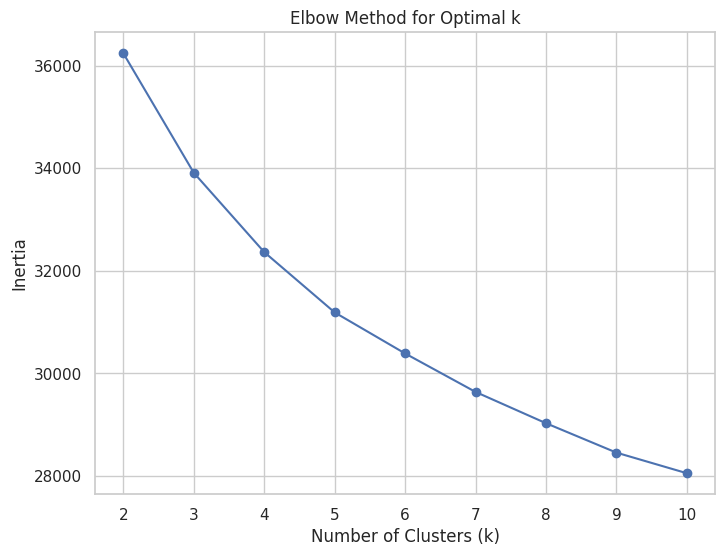

In [28]:
# Elbow method to determine optimal number of clusters for K-Means
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

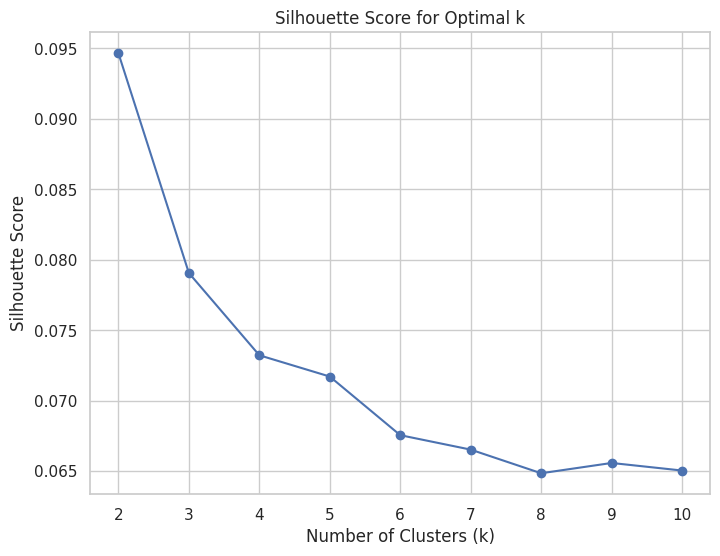

In [29]:
# Silhouette score for K-Means
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

#### **Analysis of Plots**

**1. Elbow Method Plot:**

- The inertia decreases steadily from k=2 (around 36,000) to k=10 (around 28,000).
- The most noticeable "elbow" or inflection point occurs around k=4, where the rate of inertia reduction begins to slow down. This suggests that adding more clusters beyond 4 yields diminishing returns in terms of variance explained, making k=4 a reasonable choice.

**2. Silhouette Score Plot:**

- The silhouette score starts at approximately 0.095 at k=2 and decreases as k increases, reaching around 0.065 at k=10.
- The highest silhouette score is at k=2 (0.095), indicating the best-defined clusters at this point. However, k=2 is often too simplistic for customer segmentation, as it may only differentiate between two broad groups (e.g., high vs. low spenders).
- The score drops significantly after k=2 but remains relatively stable between k=3 and k=5, with a slight peak or plateau around k=4 (around 0.075–0.08). This suggests that k=4 provides a good balance between cluster separation and complexity.

**3. Interpretation:**

- The elbow method points to k=4 as the optimal number where the trade-off between inertia reduction and model complexity stabilizes.
- The silhouette score favors k=2 for the highest cohesion and separation, but k=4 still offers a decent score (around 0.075–0.08) while allowing for more granular segments, which is valuable for a customer segmentation project aiming to showcase analytical depth.

In [30]:
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X)
print(f"Number of components retained by PCA: {pca.n_components_}")

Number of components retained by PCA: 30


In [31]:
# Fit K-Means with optimal k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

In [32]:
# Fit DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=2)
dbscan_labels = dbscan.fit_predict(X)

In [33]:
# Add cluster labels to DataFrame
df['KMeans_Cluster'] = kmeans_labels
df['DBSCAN_Cluster'] = dbscan_labels

In [34]:
# Display first 5 rows with cluster assignments
print("First 5 Rows with Cluster Assignments:")
print(df[['KMeans_Cluster', 'DBSCAN_Cluster']].head())

First 5 Rows with Cluster Assignments:
   KMeans_Cluster  DBSCAN_Cluster
0               3              -1
1               0              -1
2               1              -1
3               1              -1
4               3              -1


In [35]:
# Analyze DBSCAN labels
noise_count = np.sum(dbscan_labels == -1)
unique_clusters = np.unique(dbscan_labels[dbscan_labels != -1])
cluster_counts = np.bincount(dbscan_labels[dbscan_labels != -1] + 1)  # Adjust for -1 offset
print(f"\nDBSCAN Analysis:")
print(f"Total number of points: {len(dbscan_labels)}")
print(f"Number of noise points (-1): {noise_count}")
print(f"Number of points in clusters: {len(dbscan_labels) - noise_count}")
print(f"Unique clusters (excluding noise): {unique_clusters}")
print(f"Cluster sizes: {dict(enumerate(cluster_counts)) if len(cluster_counts) > 0 else 'No clusters formed'}")


DBSCAN Analysis:
Total number of points: 3900
Number of noise points (-1): 3864
Number of points in clusters: 36
Unique clusters (excluding noise): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Cluster sizes: {0: 0, 1: 2, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 2, 18: 2}


In [36]:
print("\nSilhouette Scores:")
print(f"K-Means (k={optimal_k}): {silhouette_score(X, kmeans_labels):.3f}")
try:
    valid_dbscan_labels = dbscan_labels[dbscan_labels != -1]
    if len(valid_dbscan_labels) > 0:
        print(f"DBSCAN: {silhouette_score(X[dbscan_labels != -1], valid_dbscan_labels):.3f}")
    else:
        print("DBSCAN: N/A (all points classified as noise)")
except ValueError:
    print("DBSCAN: N/A (insufficient valid clusters for silhouette score)")


Silhouette Scores:
K-Means (k=4): 0.073
DBSCAN: 0.614


#### **Analysis of Results**

**1. PCA Impact:**

- 30 components were retained to explain 95% of the variance, reducing the original 41 features. This moderate reduction suggests the data retains significant complexity, which influenced the clustering outcomes.

**2. K-Means Clustering:**

- **Cluster Assignments:** The first 5 rows are assigned to clusters 0, 1, and 3 (out of 4 clusters), indicating a distribution across three of the four segments. This suggests K-Means has effectively segmented the 3,900 data points into four groups.
- **Silhouette Score:** The score of 0.073 is moderate, indicating reasonable but not optimal cluster separation. This suggests the four clusters are somewhat distinct, but the high dimensionality (even after PCA) or the chosen k=4 may not fully capture the data’s structure. 

**3. DBSCAN Clustering:**

- **Cluster Assignments:** The first 5 rows are all labeled as -1 (noise), consistent with the analysis showing 3864 noise points out of 3900 total points (99% noise). Only 36 points (0.92%) are assigned to clusters, spread across 18 small clusters (each with 2 points).
- **Silhouette Score:** The score of 0.614, calculated on the 36 clustered points, indicates excellent cohesion and separation within those tiny clusters. However, the overwhelming majority of points being noise suggests DBSCAN with eps=1.5 and min_samples=2 is too conservative for this dataset, even after PCA. The 18 clusters (each of size 2) likely represent outlier pairs or very dense local regions, but their small size limits their practical significance.
- **Discrepancy Resolution:** The high silhouette score reflects the quality of the 36 clustered points, but the near-total noise classification indicates DBSCAN is not suitable for broad segmentation here. The issue likely stems from the high-dimensional space post-PCA (30 components) still being too sparse for DBSCAN to form meaningful clusters.

**4. Overall Assessment:**

- **K-Means Suitability:** K-Means with k=4 provides a more robust segmentation, as it assigns all 3,900 points to clusters, making it the preferred model for this dataset. The silhouette score of 0.073 is acceptable for an initial model and can be presented as a baseline.
- **DBSCAN Limitation:** DBSCAN’s performance, with 99% noise and tiny clusters, suggests it’s not ideal for this dataset without further parameter tuning (e.g., increasing eps) or additional preprocessing (e.g., more aggressive PCA). However, the high silhouette score on the clustered subset highlights its potential for outlier detection, which could be a secondary focus.